# Gentle introduction to Pytorch Functional

You don't need any knowledge of the inner workings of Pytorch Functional to use it.
In most cases, after seeing a few examples, you're good to go.
If you used Keras Functional API before, you don't even need any learning materials.
However, this notebooks explains Pytorch Functional a little bit deeper, in case you just want to know more stuff.

In this notebook, we'll use our built-in drawing solution for layered graphs.
Although it's not ideal, we hope it'll be just enough to demonstrate the concepts.

You can use it yourself if you have an optional dependency are installed: `networkx`. It can be installed with `pip install networkx`.

You can find the reference [in the Documentation](https://pytorch-functional.readthedocs.io/).

In [ ]:
!pip install pytorch-functional torchvision networkx matplotlib scipy tqdm

In [ ]:
import torch
from torch import nn
from pytorch_functional import FunctionalModel, Input, useful_layers, graph_algorithms

import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

## Having fun with symbolic tensors
### Simple example
We'll first look at what we can do with symbolic tensors.

In [ ]:
x = Input(shape=(5,))
y = Input(shape=(5,))
print(f"x={x}")
print(f"y={y}")
print()

z = x + y
print("After creating z = x + y:")
print(f"x={x}")
print(f"y={y}")
print(f"z={z}")

We created two symbolic tensors: `x` and `y`.
Their sum is represented by another symbolic tensor: `z`, which was added to the graph of computations.

When we print the tensors, we can see that `z` has two parents and both `x` and `y` have one child.

If we need, we can even retrieve the instances of specific children and parents.

As it is in life, you cannot change your parents, thus `.parents` are immutable. But `.children` are not!

In [ ]:
print(f"x.children={x.children}")
print(f"y.children={y.children}")

print(f"z.parents={z.parents}")

We are creating full fledged graphs now! Let's try to plot them...

In [ ]:
# To show you nicer plot, we prepared an option to show variable names in nodes of the graph.
# It requires passing the namespace, e.g. globals().
# By default, you'll see shape of the underlying Symbolic Tensor in each node.

plt.figure(figsize=(7, 4))
graph_algorithms.draw_graph(inputs=(x, y), outputs=z, node_text_namespace=globals())

We can see that addition was converted to `AddOpLayer`.

If we want to use a custom operator or function on a symbolic tensor, we need to create an nn.Module.

For simple operators like addition, Pytorch Functional will do it for us automatically!

### A deeper example

We will create another, more complicated model.

Still no neural networks, but we'll get to them, I promise!

In [ ]:
x = Input(shape=())
y = Input(shape=())

sums = x + y
diff = x - y
mult = x * y
intermediate_values = [sums, diff, mult]
outputs = sum(intermediate_values) / 3

In [ ]:
intermediate_values

We can see that the three intermediate values are children of 2 nodes and parent for 1 node.

In [ ]:
plt.figure(figsize=(10, 8))
gr = graph_algorithms.draw_graph(inputs=(x, y), outputs=outputs, node_text_namespace=globals())

Moreover, we see what Python does internally, when `sum` is called. It's just a bunch of additions! Obviously...

Let us create a Functional Model from this graph!

In [ ]:
model = FunctionalModel(inputs=(x, y), outputs=outputs)
model

In [ ]:
rx = torch.rand(
    1,
)
ry = torch.rand(
    1,
)

print(f"rx={rx}")
print(f"ry={ry}")
print(f"model(rx, ry)={model(rx, ry)}")

assert model(rx, ry) == ((rx + ry) + (rx - ry) + (rx * ry)) / 3, "Something went wrong..."

As we see, after defining the model on symbolic tensors, it works perfectly fine when launched on real data!

Right now, we were manipulating the data with `+`, `-` and `*` operators.

Most of Python's operators are already defined for symbolic tensors, e.g.: `+, -, *, /, //, %, abs`.

They will be converted to ``nn.Module`` and registered correctly in the model.

## Symbolic tensors && real layers

However, in deep learning, we rarely use just standard operations. Instead, we rely on layers to transform the data.
Let's create a small linear model with a few hidden layers!

In [ ]:
inputs = Input((4,))
x1 = nn.Linear(inputs.features, 10)(inputs)
x2 = nn.Linear(x1.features, 10)(x1)
x3 = nn.Linear(x2.features, 10)(x2)
outputs = nn.Linear(x3.features, 1)(x3)

model = FunctionalModel(inputs, outputs)
model

Looks like it was a succes. Let's see how it looks like as a graph!

In [ ]:
plt.figure(figsize=(5, 6))
graph_algorithms.draw_graph(model=model, node_text_namespace=globals())

It's a rather simple topology.

### An odd one

We'll now create a model that consists of a few towers - separate functional models.

It means we will use functional model inside another functional model. Cool, isn't it?

There'll be:
* 3 separate inputs
* 2 separate outputs

After a few layers of separated computations, the results will be concatenated, then transformed some more and returned!

On the drawing, we will see the shapes of Symbolic Tensors.

In [ ]:
def get_tower(height):
    inputs = x = Input((5,))
    for _ in range(height):
        x = nn.Linear(x.features, 10)(x)
    model = FunctionalModel(inputs, x)
    return model


towers = [get_tower(height=3 + i) for i in range(3)]
inputs = [Input((5,)) for _ in range(3)]
tower_outputs = []

for x, tower in zip(inputs, towers):
    tower_outputs.append(tower(x))

x = useful_layers.ConcatLayer(dim=1)(*tower_outputs)

out1 = nn.Linear(x.features, 5)(x)
out2 = nn.Linear(x.features, 3)(x)

model = FunctionalModel(inputs, (out1, out2))

In [ ]:
plt.figure(figsize=(18, 10))

graph_algorithms.draw_graph(model=model)

If we want, we can even "zoom in" to the inner FunctionalModel. Let's try it:

In [ ]:
plt.figure(figsize=(5, 6))
graph_algorithms.draw_graph(model=towers[0])

This can be useful, if this model is complex and has many submodels!

### Subgraphs

We can operate on subgraphs too: we can either create models from them or just draw them.

Let's use previous graph as an example.

Let's say we want a new model that shares weights with the existing one.
We want to omit the tower 1 and tower 3 computations, instead we'll provide their values "by hand" somehow.

In [ ]:
input1 = tower_outputs[0]
input2 = inputs[1]
input3 = tower_outputs[2]

plt.figure(figsize=(14, 8))

graph_algorithms.draw_graph(inputs=(input1, input2, input3), outputs=(out1, out2))

In [ ]:
model = FunctionalModel(inputs=(input1, input2, input3), outputs=(out1, out2))
print(model)

real_outputs = model(torch.rand(1, 10), torch.rand(1, 5), torch.rand(1, 10))
real_outputs

## Functional API in real models

Let us create and train a small ResNet example that will work on MNIST dataset.

To train large models quickly, you need to have a CUDA capable device.
On Colab, be sure to set "Hardware accelerator" to "GPU".

In this notebook, if CPU runtime is detected, we'll use a smaller neural network and a shorter training.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Creating dataset

ds = torchvision.datasets.MNIST(root=".", download=True, transform=torchvision.transforms.ToTensor())
train, valid = torch.utils.data.random_split(ds, [50000, 10000])

train_dl = torch.utils.data.DataLoader(
    train, batch_size=200, shuffle=True, drop_last=True, pin_memory=True, num_workers=1
)
valid_dl = torch.utils.data.DataLoader(
    valid, batch_size=200, shuffle=False, drop_last=True, pin_memory=True, num_workers=1
)

In [ ]:
def create_model_gpu():
    def shortcut_func(x, channels, stride):
        if x.channels != channels or stride != 1:
            return x(nn.Conv2d(x.channels, channels, kernel_size=1, bias=False, stride=stride))
        else:
            return nn.Identity()(x)

    inputs = Input(batch_shape=(200, 1, 28, 28))
    flow = inputs(nn.Conv2d(inputs.channels, 16, 3, padding=1))

    for group_size, width, stride in [(2, 16, 1), (2, 32, 2), (2, 64, 2)]:
        for _ in range(group_size):
            shortcut = shortcut_func(flow, width, stride)

            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, stride, 1)(flow)
            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, 1, 1)(flow)

            flow = flow + shortcut
            stride = 1

    flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
    flow = nn.MaxPool2d(kernel_size=flow.HW)(flow)(nn.Flatten())
    outs = nn.Linear(flow.features, 10)(flow)
    return inputs, outs


def create_model_cpu():
    def shortcut_func(x, channels, stride):
        if x.channels != channels or stride != 1:
            return x(nn.Conv2d(x.channels, channels, kernel_size=1, bias=False, stride=stride))
        else:
            return nn.Identity()(x)

    inputs = Input(batch_shape=(200, 1, 28, 28))
    flow = inputs(nn.Conv2d(inputs.channels, 4, 3, padding=1))

    for group_size, width, stride in [(2, 4, 2), (2, 16, 2), (2, 32, 2)]:
        for _ in range(group_size):
            shortcut = shortcut_func(flow, width, stride)

            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, stride, 1)(flow)
            flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
            flow = nn.Conv2d(flow.channels, width, 3, 1, 1)(flow)

            flow = flow + shortcut
            stride = 1

    flow = nn.BatchNorm2d(flow.channels)(flow)(nn.ReLU())
    flow = nn.MaxPool2d(kernel_size=flow.HW)(flow)(nn.Flatten())
    outs = nn.Linear(flow.features, 10)(flow)
    return inputs, outs


if device.type == "cuda":
    inputs, outputs = create_model_gpu()
else:
    inputs, outputs = create_model_cpu()

model = FunctionalModel(inputs=inputs, outputs=outputs).to(device)
optimizer = torch.optim.Adam(model.parameters())

It is a large model to draw! But let's try it anyway...

In [ ]:
plt.figure(figsize=(50, 5), constrained_layout=True)
graph_algorithms.draw_graph(
    model=model, edge_text_func=lambda x: "", node_text_namespace=globals(), rotate_graph=True
)

In [ ]:
def traininig(model, optimizer, epochs):
    model.train()

    loss_fn = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        mean_acc = 0
        mean_acc_n = 0

        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            model.zero_grad()
            outs = model(x)

            loss = loss_fn(outs, y)
            loss.backward()
            optimizer.step()

            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy * x.shape[0]
            mean_acc_n += x.shape[0]

        print(f"Average training accuracy in epoch {epoch + 1}: {mean_acc / mean_acc_n * 100 : <6.3f}%")


traininig(model, optimizer, epochs=5 if device.type == "cuda" else 2)

In [ ]:
def evaluation(model):
    model.eval()

    mean_acc = 0
    mean_acc_n = 0

    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in valid_dl:
            x = x.to(device)
            y = y.to(device)
            outs = model(x)
            accuracy = torch.mean((outs.argmax(1) == y).to(torch.float)).detach().cpu()
            mean_acc += accuracy
            mean_acc_n += 1

    print(f"Average validation accuracy: {mean_acc / mean_acc_n * 100 : <6.3f}%")


evaluation(model)

This network is overfitting! Can you fix it somehow?

## Acceleration

Hurray! We've trained a network that is pretty accurate. What else can we improve?

Maybe performance? With Pytorch Functional you can enable CUDA Graphs using just one argument.

This will work especially well for models with many small layers or where CPU calls are slower than GPU kernel execution.

In [ ]:
if torch.cuda.is_available():
    inputs, outputs = create_model_gpu()
    model = FunctionalModel(inputs=inputs, outputs=outputs, enable_cuda_graphs=True)
    optimizer = torch.optim.Adam(model.parameters())

    traininig(model, optimizer, epochs=5)
    evaluation(model)
else:
    print("CUDA Graphs require CUDA capable device!")

# Automatic code generation

Pytorch Functional also generates forward function code automatically. We are even able too peek what was generated.

We'll tweak one of the constants of code generator just for the sake of presentation:

In [ ]:
from pytorch_functional import config

config.CODEGEN_MIN_LOOP_LENGTH = 2

By default, Pytorch Functional creates for loops only when there is _a lot_ of sequential layers.
We are decreasing this number to see some loops.

Now we will define the model:

In [ ]:
from pytorch_functional import add_to_model

x1 = Input(shape=(3, 32, 32))

x2 = nn.Conv2d(x1.C, 16, 3, padding=1)(x1)
x3 = nn.Conv2d(x2.C, 16, 3, padding=1)(x2)
x4 = nn.Conv2d(x3.C, 16, 3, padding=1)(x3)

x11 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x12 = nn.Conv2d(x11.C, 16, 3, padding=1)(x11)
x13 = nn.Conv2d(x12.C, 16, 3, padding=1)(x12)
x14 = nn.Conv2d(x13.C, 16, 3, padding=1)(x13)
x15 = nn.Conv2d(x14.C, 16, 3, padding=1)(x14)

x21 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x22 = nn.Conv2d(x21.C, 16, 3, padding=1)(x21)
x23 = nn.Conv2d(x22.C, 16, 3, padding=1)(x22)

x5 = add_to_model(torch.concat, [x15, x23], dim=1)
x6 = nn.Flatten()(x5)
x7 = nn.Linear(x6.features, 1)(x6)

model = FunctionalModel(inputs=x1, outputs=x7)

In [26]:
from pytorch_functional import add_to_model

x1 = Input(shape=(3, 32, 32))

x2 = nn.Conv2d(x1.C, 16, 3, padding=1)(x1)
x3 = nn.Conv2d(x2.C, 16, 3, padding=1)(x2)
x4 = nn.Conv2d(x3.C, 16, 3, padding=1)(x3)

x11 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x12 = nn.Conv2d(x11.C, 16, 3, padding=1)(x11)
x13 = nn.Conv2d(x12.C, 16, 3, padding=1)(x12)
x14 = nn.Conv2d(x13.C, 16, 3, padding=1)(x13)
x15 = nn.Conv2d(x14.C, 16, 3, padding=1)(x14)

x21 = nn.Conv2d(x4.C, 16, 3, padding=1)(x4)
x22 = nn.Conv2d(x21.C, 16, 3, padding=1)(x21)
x23 = nn.Conv2d(x22.C, 16, 3, padding=1)(x22)

x5 = add_to_model(torch.concat, [x15, x23], dim=1)
x6 = nn.Flatten()(x5)
x7 = nn.Linear(x6.features, 1)(x6)

model = FunctionalModel(inputs=x1, outputs=x7)

Let's look at the generated source of `forward` function and at the plotted graph.

We can see that code generator detects sequential layers and converts them to execute in a loop.

By default, it only does for long sequences, because it improves their performance.
We tweaked a constant before, so that all sequences of layers longer than 1 are converted to a loop.

In [27]:
print(model._generated_forward_source)

def _generated_forward(self,i00):
    l = self._execution_order_layers
    h02 = i00
    for layer in l[0:3]:
        h02 = layer(h02)
    h05 = h02
    for layer in l[3:6]:
        h05 = layer(h05)
    h10 = h02
    for layer in l[6:11]:
        h10 = layer(h10)
    h11 = l[11](h10,h05)
    o00 = h11
    for layer in l[12:14]:
        o00 = layer(o00)
    return o00



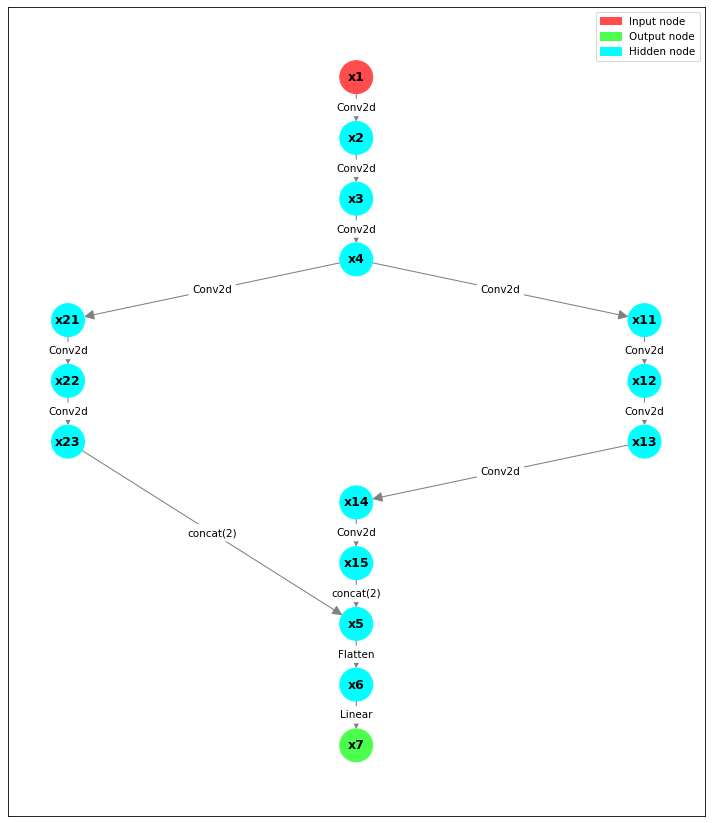

In [28]:
plt.figure(figsize=(12, 14), dpi=75)
graph_algorithms.draw_graph(model=model, node_text_namespace=globals())